In [1]:
cpu_count = 100
import os
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={cpu_count}'
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, Predictive
import numpyro.distributions as dist
import arviz as az

In [4]:
n_chains = 10

In [5]:
key = random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
def prev_stats(params, eir, eta):
    p = dmeq.default_parameters()
    for k, v in params.items():
        p[k] = v
    p['EIR'] = eir
    p['eta'] = eta
    solution = dmeq.solve(p)
    return jnp.array([
        solution[0, 3:10].sum() / solution[2, 3:10].sum(), # Prev 2 - 10
        solution[0, 10:].sum() / solution[2, 10:].sum(), # Prev 10+
        solution[1, :5].sum() / solution[2, :5].sum(), # Inc 0 - 5
        solution[1, 5:15].sum() / solution[2, 5:15].sum(), # Inc 5 - 15
        solution[1, 15:].sum() / solution[2, 15:].sum() # Inc 15+
    ])

In [7]:
def prev_stats_multisite(params, eirs, etas):
    return jnp.ravel(vmap(prev_stats, in_axes=[None, 0, 0])(params, eirs, etas))

In [8]:
population = 100_000
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
key, key_i = random.split(key)
etas = 1. / (random.normal(key_i, shape=EIRs.shape, dtype=jnp.float64) * 2 * 365 + 20*365)

In [9]:
def model(prev=None, impl=prev_stats_multisite):
    # Pre-erythrocytic immunity
    kb = numpyro.sample('kb', dist.TruncatedDistribution(dist.Normal(2., 1.), low=.1, high=10.))
    ub = numpyro.sample('ub', dist.TruncatedDistribution(dist.Normal(5., 1.), low=1., high=10.))
    b0 = numpyro.sample('b0', dist.Beta(1., 1.))
    IB0 = numpyro.sample('IB0', dist.LeftTruncatedDistribution(dist.Normal(50., 10.), low=1.))
    
    # Clinical immunity
    kc = numpyro.sample('kc', dist.Gamma(2., 1.))
    uc = numpyro.sample('uc', dist.Gamma(5., 1.))
    phi0 = numpyro.sample('phi0', dist.Beta(5., 1.))
    phi1 = numpyro.sample('phi1', dist.Beta(1., 2.))
    IC0 = numpyro.sample('IC0', dist.LeftTruncatedDistribution(dist.Normal(100., 10.), low=1.))
    PM = numpyro.sample('PM', dist.Beta(1., 1.))
    dm = numpyro.sample('dm', dist.LeftTruncatedDistribution(dist.Normal(200., 10.), low=0.))
    
    # Detection immunity
    # kd = numpyro.sample('kd', dist.Gamma(2., 1))
    # ud = numpyro.sample('ud', dist.Gamma(5., 1.))
    # d1 = numpyro.sample('d1', dist.Beta(1., 2.))
    # ID0 = numpyro.sample('ID0', dist.LeftTruncatedDistribution(dist.Normal(25., 1.), low=1.))
    # fd0 = numpyro.sample('fd0', dist.Beta(1., 1.))
    # gd = numpyro.sample('gd', dist.Gamma(1., 1.))
    # ad0 = numpyro.sample(
    #     'ad0',
    #     dist.TruncatedDistribution(dist.Normal(30. * 365., 1.), low=20. * 365., high=40.*365)
    # )
    
    # du = numpyro.sample('du', dist.LeftTruncatedDistribution(dist.Normal(50., 1.), low=0.))
    
    # FOIM
    # cd = numpyro.sample('cd', dist.Beta(1., 2.))
    # cu = numpyro.sample('cu', dist.Beta(1., 5.))
    # g_inf = numpyro.sample('g_inf', dist.Gamma(3., 1.))
    
    pred_prev = impl({
        'kb': kb,
        'ub': ub,
        'b0': b0,
        'IB0': IB0,
        'kc': kc,
        'uc': uc,
        'IC0': IC0,
        'phi0': phi0,
        'phi1': phi1,
        'PM': PM,
        'dm': dm,
        # 'kd': kd,
        # 'ud': ud,
        # 'd1': d1,
        # 'ID0': ID0,
        # 'fd': fd0,
        # 'gd': gd,
        # 'ad0': ad0,
        # 'rU': 1. / du,
        # 'cd': cd,
        # 'cu': cu,
        # 'g_inf': g_inf
    }, EIRs, etas)
    
    numpyro.sample(
        'obs',
        dist.Independent(
            dist.Binomial(total_count=population, probs=pred_prev),
            1
        ),
        obs=prev
    )

In [10]:
from jax import pmap, tree_map
import jax

n_samples = int(1e5)
def pmap_prior(k):
    return Predictive(model, num_samples=n_samples // cpu_count)(k)

key, *keys = random.split(key, num=cpu_count + 1)
prior = pmap(pmap_prior, in_axes=0)(jnp.stack(keys))
prior = jax.tree_map(lambda x: jnp.reshape(x, (n_samples, -1)), prior)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [11]:
_ = prior.pop('obs')

In [12]:
X, x_def = jax.tree_util.tree_flatten(prior)
X = jnp.concatenate(X, axis=1)

In [13]:
def sample_y(x):
    params = jax.tree_util.tree_unflatten(x_def, x)
    return prev_stats_multisite(params, EIRs, etas)

In [14]:
y = pmap(vmap(jit(sample_y)))(
    jnp.reshape(X, (cpu_count, X.shape[0] // cpu_count,) + X.shape[1:])
)
y = jnp.reshape(y, (X.shape[0],) + y.shape[2:])

In [15]:
def standardise(x, mean, std):
    return (x - mean) / std
    
def inverse_standardise(x, mean, std):
    return x * std + mean

In [16]:
X_mean, X_std = jnp.mean(X, axis=0), jnp.std(X, axis=0)
y_mean, y_std = jnp.mean(y, axis=0), jnp.std(y, axis=0)

X_stand = standardise(X, X_mean, X_std)
y_stand = standardise(y, y_mean, y_std)

In [17]:
from flax import linen as nn
from jax.tree_util import tree_leaves

class Surrogate(nn.Module):
    units: int
    n_hidden: int
    n_output: int

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.units) for _ in range(self.n_hidden)]
        for i, lyr in enumerate(layers):
            x = lyr(x)
            x = nn.relu(x)
        return nn.Dense(self.n_output)(x)

In [18]:
surrogate_model = Surrogate(units=288, n_hidden=3, n_output=y.shape[1])
surrogate_params = surrogate_model.init(key, X)

In [19]:
from jax.nn import softplus

@jit
def log_cosh(params, x_batched, y_batched):
    # Define a numerically stable log cosh for a single pair (x,y)
    def error(x, y):
        pred = surrogate_model.apply(params, x)
        diff = y - pred
        return jnp.mean(diff + softplus(-2 * diff) - jnp.log(2.))
    # Vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(vmap(error)(x_batched, y_batched), axis=0)

In [20]:
import optax
from jax import value_and_grad

In [21]:
tx = optax.adam(learning_rate=.001)
opt_state = tx.init(surrogate_params)
loss_grad_fn = value_and_grad(log_cosh)

In [22]:
batch_size = 100
n_batches = X.shape[0] // batch_size
X_batched = jnp.reshape(
    X_stand,
    (n_batches, batch_size) + X.shape[1:]
)
y_batched = jnp.reshape(
    y_stand,
    (n_batches, batch_size) + y.shape[1:]
)

In [23]:
%%time
epochs = 100

for i in range(epochs):
    key, key_i = random.split(key)
    for b in random.permutation(key_i, n_batches, independent=True):
        loss_val, grads = loss_grad_fn(surrogate_params, X_batched[b], y_batched[b])
        updates, opt_state = tx.update(grads, opt_state)
        surrogate_params = optax.apply_updates(surrogate_params, updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), log_cosh(surrogate_params, X_stand, y_stand))

Loss step 0:  0.0045851806167138826
Loss step 10:  0.0007048084756431442
Loss step 20:  0.0003736989996548056
Loss step 30:  0.00025143371245133346
Loss step 40:  0.00018660834509435164
Loss step 50:  0.0001378588911982376
Loss step 60:  0.0002625206024482464
Loss step 70:  0.00021563635439890606
Loss step 80:  9.163722863547258e-05
Loss step 90:  0.00011766617030707177
CPU times: user 1h 13min 40s, sys: 8min 22s, total: 1h 22min 3s
Wall time: 29min 25s


In [24]:
def prev_stats_multisite_surrogate(model_params, EIRs, etas):
    return inverse_standardise(
        surrogate_model.apply(
            surrogate_params,
            standardise(
                jax.flatten_util.ravel_pytree(model_params)[0],
                X_mean,
                X_std
            )
        ),
        y_mean,
        y_std
    )

In [25]:
true_values = Predictive(model, num_samples=1)(key)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [26]:
true_values

{'IB0': Array([47.33754857], dtype=float64),
 'IC0': Array([94.54366449], dtype=float64),
 'PM': Array([0.1798907], dtype=float64),
 'b0': Array([0.72416149], dtype=float64),
 'dm': Array([192.18656311], dtype=float64),
 'kb': Array([2.94980955], dtype=float64),
 'kc': Array([1.076653], dtype=float64),
 'obs': Array([[  723,   930,     4,     5,     8, 25403, 18577,   244,   403,
           427, 47308, 28788,   782,  1070,  1012, 52357, 31152,   922,
          1254,  1306, 75601, 44810,  2680,  3522,  3729, 79985, 49280,
          3455,  4415,  4679, 88259, 60678,  5911,  7480,  7971]],      dtype=int64),
 'phi0': Array([0.96146541], dtype=float64),
 'phi1': Array([0.63204355], dtype=float64),
 'ub': Array([4.5360091], dtype=float64),
 'uc': Array([7.69227105], dtype=float64)}

In [27]:
observations = true_values['obs'][0]

In [28]:
observations

Array([  723,   930,     4,     5,     8, 25403, 18577,   244,   403,
         427, 47308, 28788,   782,  1070,  1012, 52357, 31152,   922,
        1254,  1306, 75601, 44810,  2680,  3522,  3729, 79985, 49280,
        3455,  4415,  4679, 88259, 60678,  5911,  7480,  7971],      dtype=int64)

In [29]:
# from numpyro.contrib.tfp.mcmc import RandomWalkMetropolis
# import tensorflow_probability as tfp

In [30]:
n_samples = 100
n_warmup = 500

# kernel = RandomWalkMetropolis(
#     model,
#     new_state_fn=tfp.substrates.jax.mcmc.random_walk_normal_fn(scale=.04)
# )

from numpyro.infer import NUTS

kernel = NUTS(model)

mcmc = MCMC(
    kernel,
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
)
mcmc.run(key, observations, prev_stats_multisite)
mcmc.print_summary(prob=0.7)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     45.27      3.55     45.21     41.86     48.91    520.41      1.01
       IC0     97.92      9.22     97.58     87.34    107.07    914.90      1.00
        PM      0.50      0.28      0.50      0.05      0.71   1140.33      1.00
        b0      0.73      0.01      0.73      0.72      0.74    532.56      1.01
        dm    201.08      9.86    200.89    192.34    212.73   1105.66      1.00
        kb      2.31      0.33      2.27      1.96      2.54    450.88      1.01
        kc      1.40      0.67      1.23      0.73      1.56    401.35      1.01
      phi0      0.96      0.03      0.96      0.94      0.99    446.53      1.02
      phi1      0.64      0.04      0.64      0.59      0.69    479.70      1.02
        ub      4.88      0.81      4.88      4.03      5.67    988.28      1.00
        uc      5.43      2.18      5.17      2.85      7.07    887.77      1.01

Number of divergences: 0


In [31]:
# kernel = RandomWalkMetropolis(
#     model,
#     new_state_fn=tfp.substrates.jax.mcmc.random_walk_normal_fn(scale=.04)
# )

mcmc_surrogate = MCMC(
    NUTS(model),
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
)
mcmc_surrogate.run(key, observations, prev_stats_multisite_surrogate)
mcmc_surrogate.print_summary(prob=0.7)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]


                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     45.77      3.69     45.83     42.26     49.69    546.01      1.01
       IC0     97.19      9.76     96.98     86.54    106.80    835.87      1.00
        PM      0.50      0.28      0.49      0.09      0.74   1015.89      1.00
        b0      0.74      0.01      0.73      0.73      0.74    521.72      1.01
        dm    201.99      9.51    201.82    191.00    210.17    908.08      1.00
        kb      2.33      0.31      2.32      1.95      2.60    541.80      1.01
        kc      1.39      0.61      1.21      0.73      1.54    411.31      1.01
      phi0      0.96      0.03      0.96      0.93      0.99    429.54      1.01
      phi1      0.63      0.04      0.63      0.59      0.68    448.71      1.01
        ub      4.84      0.86      4.85      3.99      5.74   1044.73      1.00
        uc      5.22      2.10      4.91      2.68      6.84    802.99      1.02

Number of divergences: 0


In [32]:
prior = Predictive(model, num_samples=600)(key)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [33]:
prior_surrogate = Predictive(model, num_samples=600)(key, impl=prev_stats_multisite_surrogate)

In [34]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(
    model,
    posterior_samples
)(key, observations, prev_stats_multisite)

In [35]:
posterior_samples_surrogate = mcmc_surrogate.get_samples()
posterior_predictive_surrogate = Predictive(
    model,
    posterior_samples_surrogate
)(key, observations, prev_stats_multisite_surrogate)

In [36]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [37]:
pyro_data_surrogate = az.from_numpyro(
    mcmc_surrogate,
    prior=prior_surrogate,
    posterior_predictive=posterior_predictive_surrogate
)

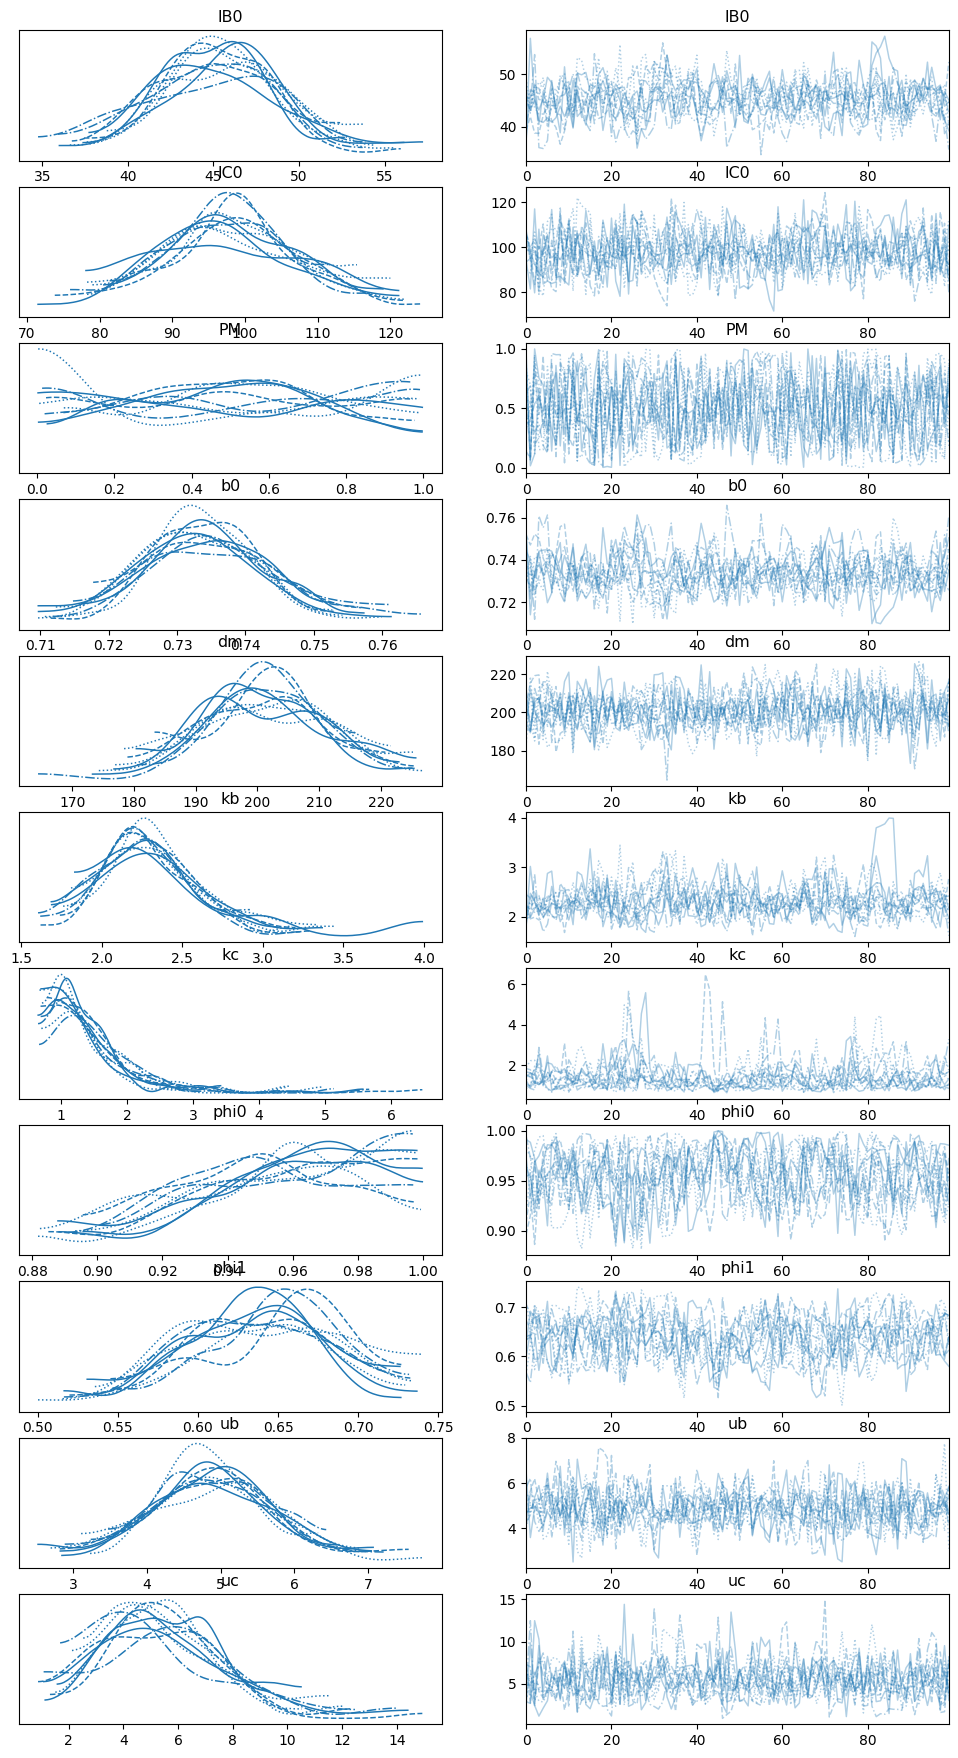

In [38]:
az.rcParams["plot.max_subplots"] = 200
axs = az.plot_trace(pyro_data)

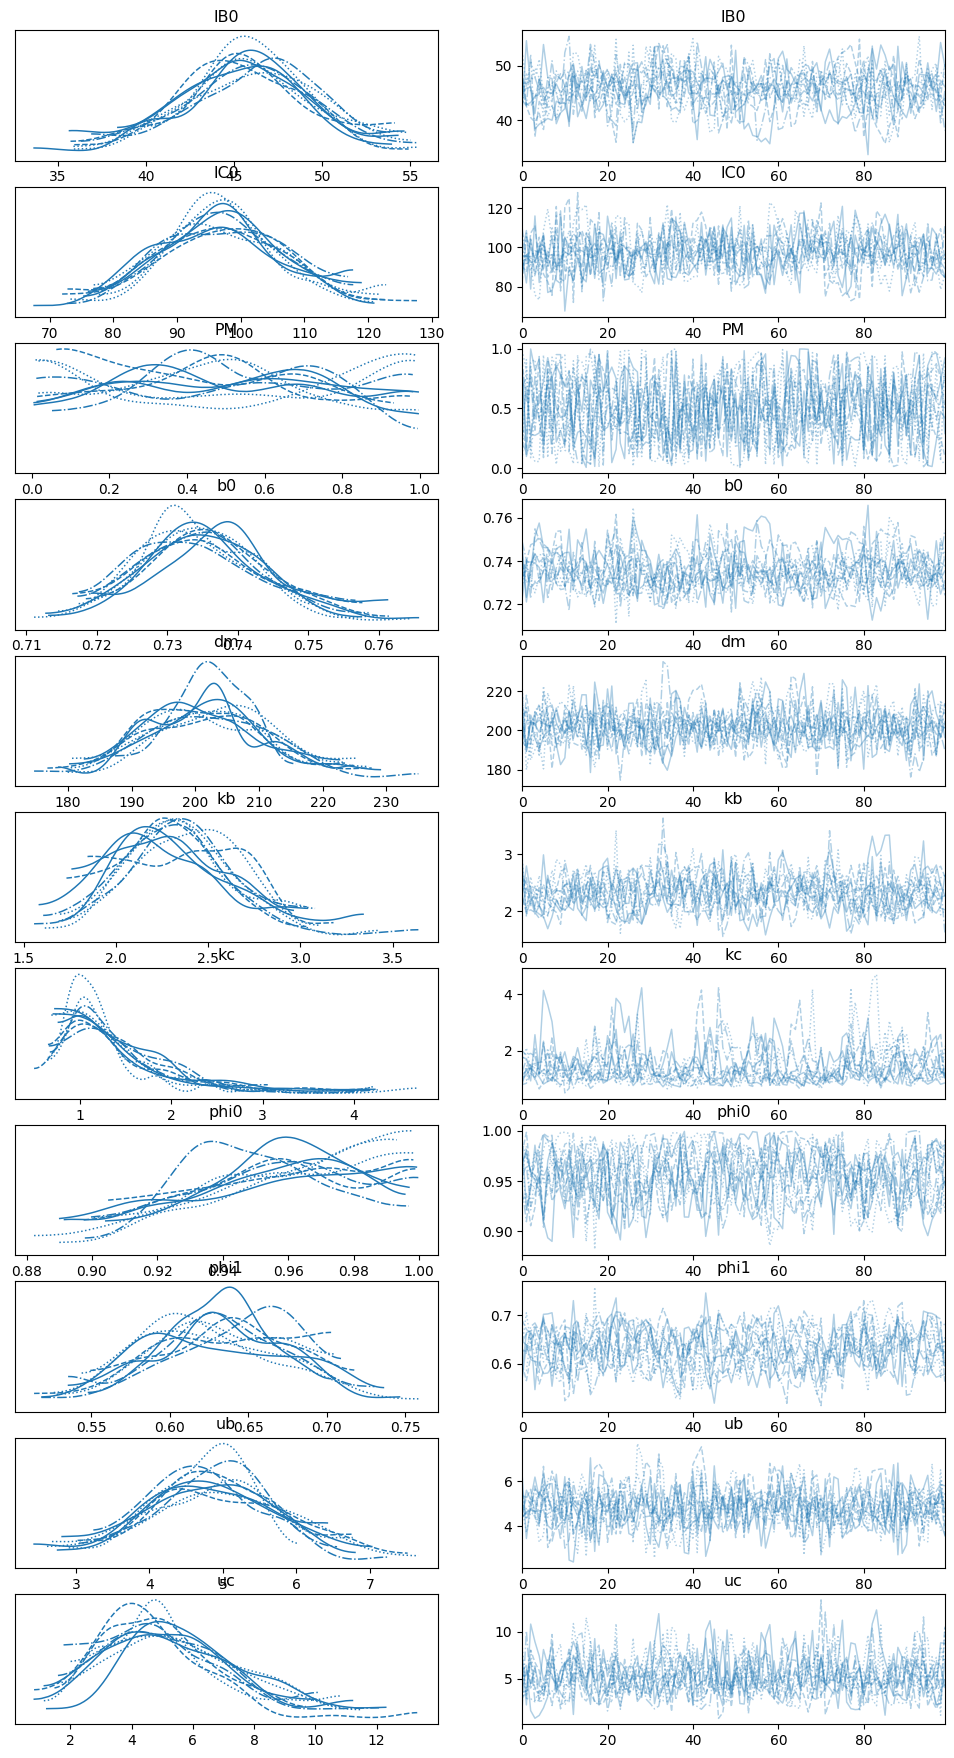

In [39]:
axs = az.plot_trace(pyro_data_surrogate)

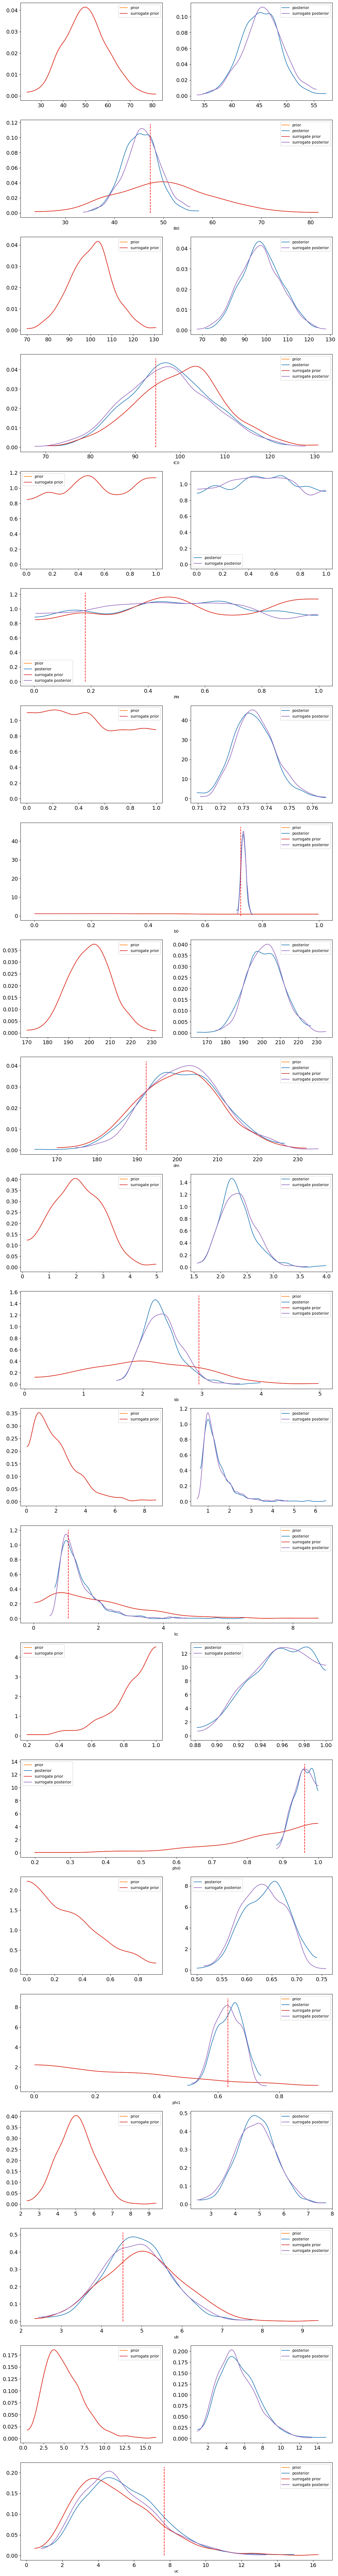

In [40]:
keys = list(pyro_data.prior.data_vars.keys())
axs = az.plot_dist_comparison(pyro_data)
axs = az.plot_dist_comparison(
    pyro_data_surrogate,
    ax=axs
)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )
    s_prior_lines = [axs[i, 0].get_lines()[1], axs[i, 2].get_lines()[2]]
    s_posterior_lines = [axs[i, 1].get_lines()[1], axs[i, 2].get_lines()[3]]
    for s_prior_line in s_prior_lines:
        s_prior_line.set_color('C3')
        s_prior_line.set_label('surrogate prior')
    for s_posterior_line in s_posterior_lines:
        s_posterior_line.set_color('C4')
        s_posterior_line.set_label('surrogate posterior')
    
    for j in range(3):
        axs[i, j].legend()

In [41]:
from scipy.stats import wasserstein_distance
import pandas as pd

In [42]:
pd.DataFrame({
    'parameter': list(posterior_samples.keys()),
    'Wd': [
        wasserstein_distance(posterior_samples[k], posterior_samples_surrogate[k])
        for k in posterior_samples.keys()
    ]
}).sort_values('Wd')

parameter        Wd
7       phi0  0.001036
3         b0  0.001233
8       phi1  0.007422
2         PM  0.008656
6         kc  0.030024
5         kb  0.036427
9         ub  0.060545
10        uc  0.208196
0        IB0  0.541206
1        IC0  0.834672
4         dm  0.917602

In [ ]:
def plot_f(names, values, impl):
    values = jnp.meshgrid(*values)
    p = dict(zip(names, values))
    
    def prev(p, impl):
        return impl(p, EIRs[0], etas[0], impl)[0]
    
    prev_space, prev_grad = vmap(
        vmap(
            value_and_grad(prev),
            in_axes=({n: 0 for n in names}, None),
            out_axes=0
        ),
        in_axes=({n: 1 for n in names}, None),
        out_axes=1
    )(p, impl)
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    surf = ax.plot_surface(b0, kb, dmeq_prev_space, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

n = 50
plot_f(['b0', 'kb'], [jnp.linspace(0, 1, num=n), jnp.linspace(0, 5, num=n)], prev_stats)